<a href="https://colab.research.google.com/github/edzinic1/Artificial-Intelligence-Project/blob/kod/Projekat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dijagnoza bolesti pacijenta na osnovu zadanih simptoma

## Analiza dataseta kroz histograme

In [ ]:
# 1. Biblioteke
import pandas as pd
import matplotlib.pyplot as plt

# 2. Učitavanje CSV fajlova
df = pd.read_csv('/content/dataset.csv')
severity_df = pd.read_csv('/content/Symptom-severity.csv')
description_df = pd.read_csv('/content/symptom_Description.csv')
precaution_df = pd.read_csv('/content/symptom_precaution.csv')

# 3. Čišćenje kolona i vrijednosti
df.columns = df.columns.str.strip().str.lower()
severity_df.columns = severity_df.columns.str.strip()
severity_df['Symptom'] = severity_df['Symptom'].str.strip().str.lower()
description_df.columns = description_df.columns.str.strip()
description_df['Disease'] = description_df['Disease'].str.strip().str.lower()
precaution_df.columns = precaution_df.columns.str.strip()
precaution_df['Disease'] = precaution_df['Disease'].str.strip().str.lower()

# 4. Prikaz kolona i osnovne informacije
print("Kolone u glavnom datasetu:", df.columns.tolist())
print("Prvih 5 redova:\n", df.head())
print("\nBroj unikatnih bolesti:", df['disease'].nunique())


Kolone u glavnom datasetu: ['disease', 'symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5', 'symptom_6', 'symptom_7', 'symptom_8', 'symptom_9', 'symptom_10', 'symptom_11', 'symptom_12', 'symptom_13', 'symptom_14', 'symptom_15', 'symptom_16', 'symptom_17']
Prvih 5 redova:
             disease   symptom_1              symptom_2              symptom_3  \
0  Fungal infection     itching              skin_rash   nodal_skin_eruptions   
1  Fungal infection   skin_rash   nodal_skin_eruptions    dischromic _patches   
2  Fungal infection     itching   nodal_skin_eruptions    dischromic _patches   
3  Fungal infection     itching              skin_rash    dischromic _patches   
4  Fungal infection     itching              skin_rash   nodal_skin_eruptions   

              symptom_4 symptom_5 symptom_6 symptom_7 symptom_8 symptom_9  \
0   dischromic _patches       NaN       NaN       NaN       NaN       NaN   
1                   NaN       NaN       NaN       NaN       NaN       NaN 

In [ ]:
# 5. Spajanje svih simptoma u jedan niz
symptom_cols = [col for col in df.columns if col.startswith("symptom")]
all_symptoms = pd.Series(dtype=str)
for col in symptom_cols:
    all_symptoms = pd.concat([all_symptoms, df[col]])

all_symptoms = all_symptoms.dropna().astype(str).str.strip().str.lower()
print("Ukupno pronađenih simptoma (uključujući duplikate):", len(all_symptoms))

symptom_freq = all_symptoms.value_counts()

Ukupno pronađenih simptoma (uključujući duplikate): 36648


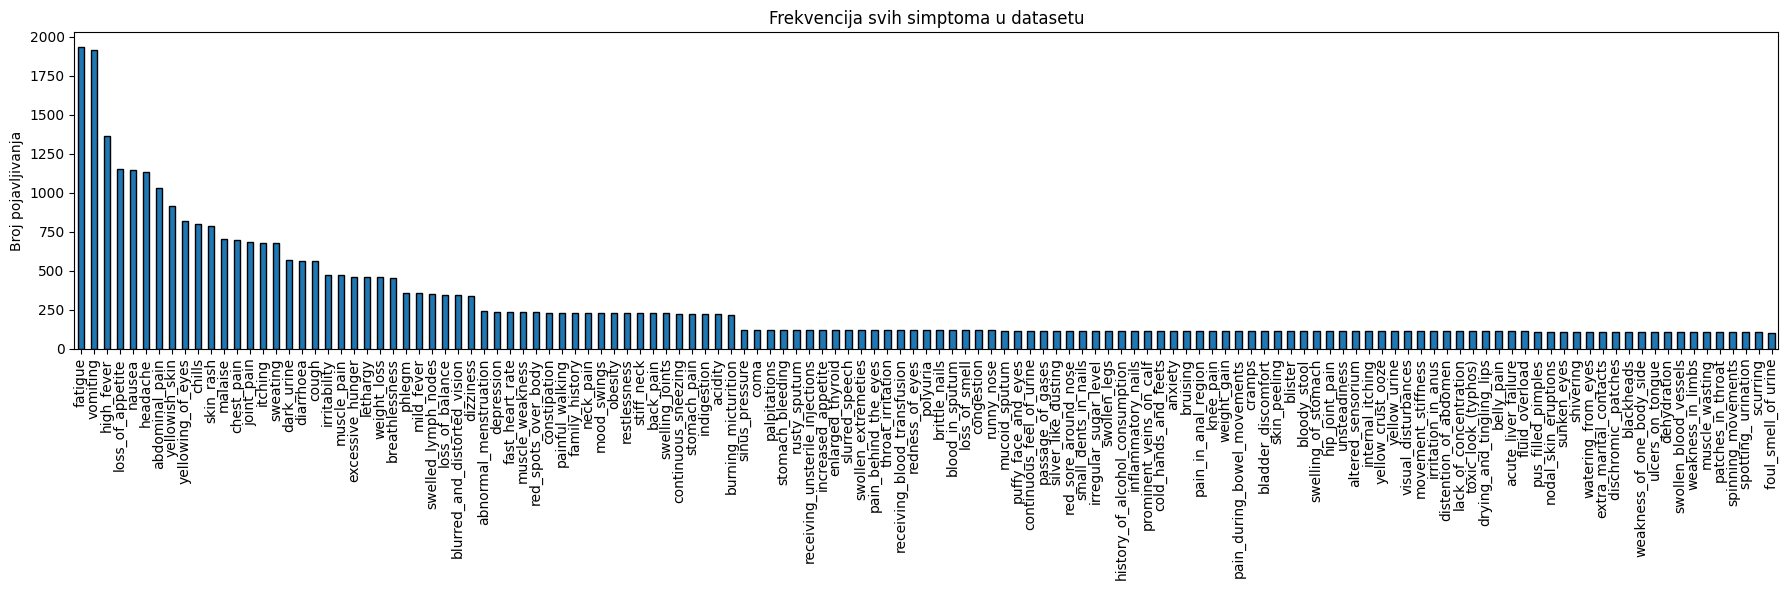

In [ ]:
# 6. Frekvencija simptoma
if symptom_freq.empty:
    print("Nema validnih simptoma za prikaz histograma.")
else:
    plt.figure(figsize=(18, 6))
    symptom_freq.plot(kind='bar', edgecolor='black')
    plt.title("Frekvencija svih simptoma u datasetu")
    plt.ylabel("Broj pojavljivanja")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

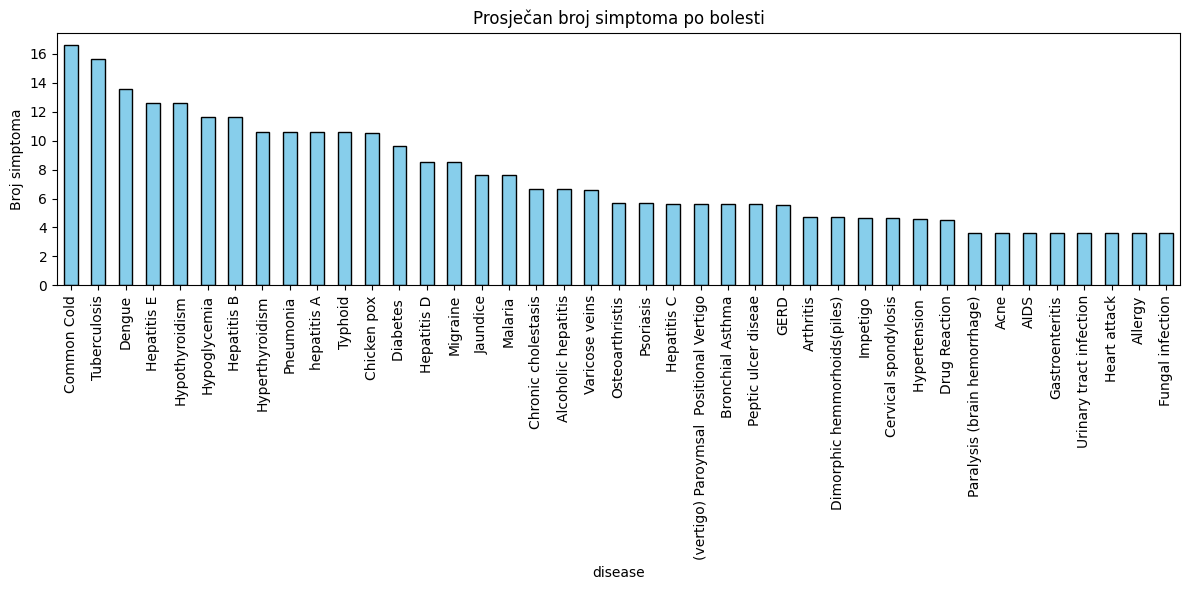

In [ ]:
# 7. Broj simptoma po bolesti
df['broj_simptoma'] = df[symptom_cols].notna().sum(axis=1)
simptom_po_bolesti = df.groupby('disease')['broj_simptoma'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
simptom_po_bolesti.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Prosječan broj simptoma po bolesti")
plt.ylabel("Broj simptoma")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

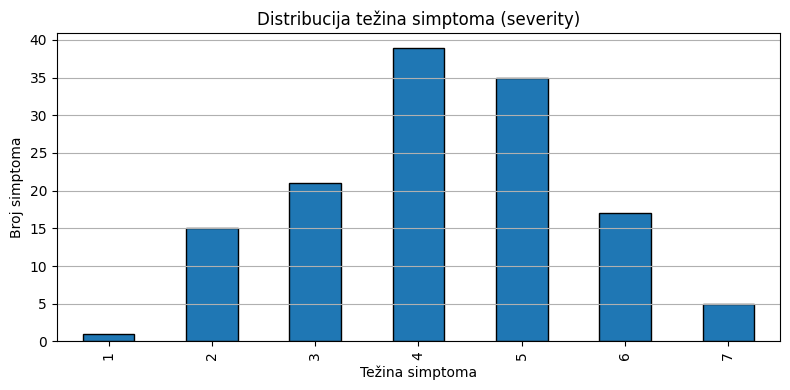

In [ ]:
# 8. Histogram težina simptoma
symptom_weight_freq = severity_df['weight'].value_counts().sort_index()

plt.figure(figsize=(8, 4))
symptom_weight_freq.plot(kind='bar', edgecolor='black')
plt.title("Distribucija težina simptoma (severity)")
plt.xlabel("Težina simptoma")
plt.ylabel("Broj simptoma")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

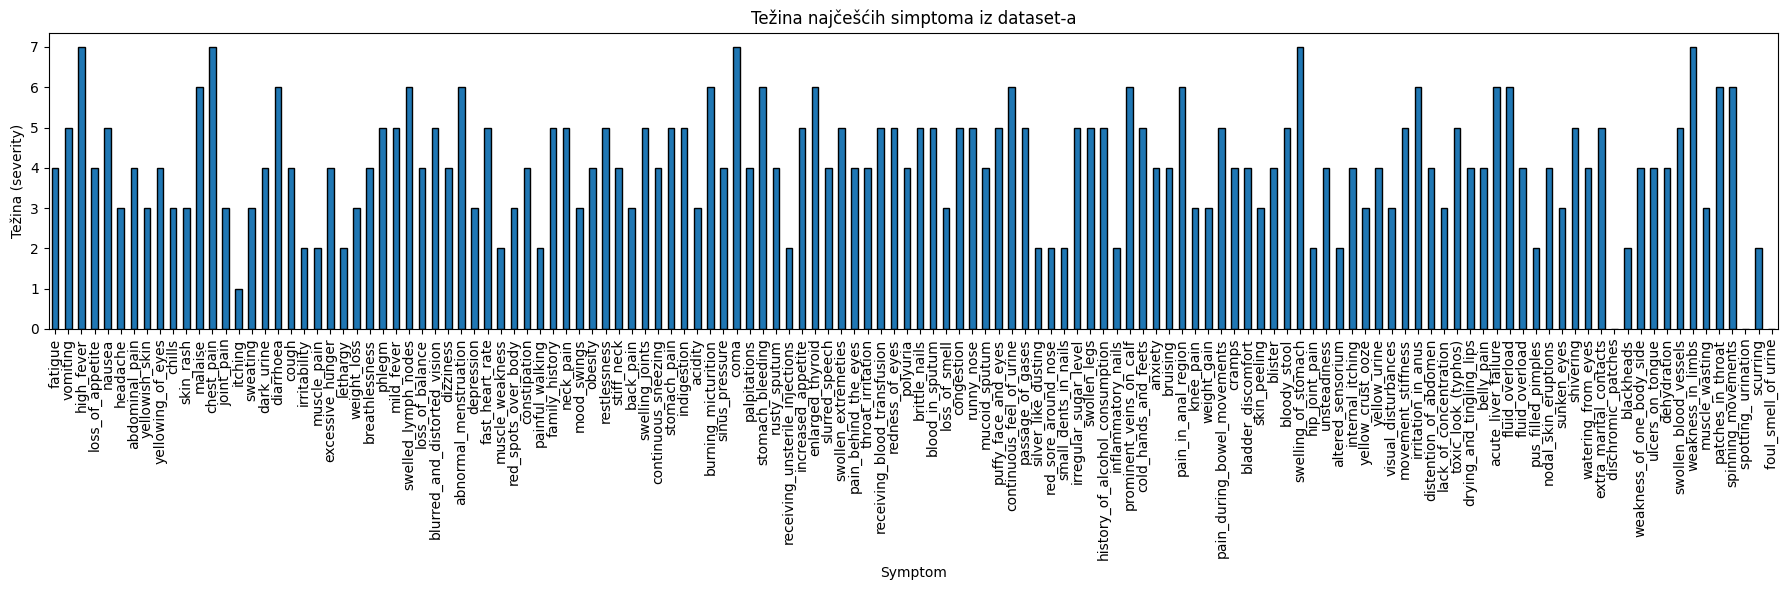

In [ ]:
# 9. Histogram težine najčešćih simptoma
merged = pd.merge(
    symptom_freq.rename("frekvencija").reset_index().rename(columns={'index': 'Symptom'}),
    severity_df,
    on='Symptom',
    how='left'
)

plt.figure(figsize=(18, 6))
merged.sort_values(by='frekvencija', ascending=False).set_index('Symptom')['weight'].plot(kind='bar', edgecolor='black')
plt.title("Težina najčešćih simptoma iz dataset-a")
plt.ylabel("Težina (severity)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Kreiranje modela i testiranje


Učitavanje potrebnih biblioteka

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
from google.colab import files

Učitavanje dataseta

In [ ]:
df = pd.read_csv("dataset.csv")
df.fillna("none", inplace=True)

In [ ]:
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,none,none,none,none,none,none,none,none,none,none,none,none,none
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,none,none,none,none,none,none,none,none,none,none,none,none,none,none
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,none,none,none,none,none,none,none,none,none,none,none,none,none,none
3,Fungal infection,itching,skin_rash,dischromic _patches,none,none,none,none,none,none,none,none,none,none,none,none,none,none
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,none,none,none,none,none,none,none,none,none,none,none,none,none,none


Spajanje svih simptoma u jednu listu koja opisuje bolest Npr. Symptom_1 = 'fever', Symptom_2 = 'headache', Symptom_3 = 'chills'

ovo je izlaz koda ['fever', 'headache', 'chills']

In [ ]:
symptom_columns = [col for col in df.columns if col.startswith("Symptom_")]
df["all_symptoms"] = df[symptom_columns].values.tolist()
df["all_symptoms"] = df["all_symptoms"].apply(lambda x: [s.strip() for s in x if s != "none"])

In [ ]:
# Prikaz podataka nakon dodavanja kolone all_symptoms
df[["Disease"] + symptom_columns + ["all_symptoms"]]

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17,all_symptoms
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,none,none,none,none,none,none,none,none,none,none,none,none,none,"[itching, skin_rash, nodal_skin_eruptions, dis..."
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,none,none,none,none,none,none,none,none,none,none,none,none,none,none,"[skin_rash, nodal_skin_eruptions, dischromic _..."
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,none,none,none,none,none,none,none,none,none,none,none,none,none,none,"[itching, nodal_skin_eruptions, dischromic _pa..."
3,Fungal infection,itching,skin_rash,dischromic _patches,none,none,none,none,none,none,none,none,none,none,none,none,none,none,"[itching, skin_rash, dischromic _patches]"
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,none,none,none,none,none,none,none,none,none,none,none,none,none,none,"[itching, skin_rash, nodal_skin_eruptions]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,(vertigo) Paroymsal Positional Vertigo,vomiting,headache,nausea,spinning_movements,loss_of_balance,unsteadiness,none,none,none,none,none,none,none,none,none,none,none,"[vomiting, headache, nausea, spinning_movement..."
4916,Acne,skin_rash,pus_filled_pimples,blackheads,scurring,none,none,none,none,none,none,none,none,none,none,none,none,none,"[skin_rash, pus_filled_pimples, blackheads, sc..."
4917,Urinary tract infection,burning_micturition,bladder_discomfort,foul_smell_of urine,continuous_feel_of_urine,none,none,none,none,none,none,none,none,none,none,none,none,none,"[burning_micturition, bladder_discomfort, foul..."
4918,Psoriasis,skin_rash,joint_pain,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,none,none,none,none,none,none,none,none,none,none,none,"[skin_rash, joint_pain, skin_peeling, silver_l..."


U ovom dijelu prvo pravimo listu koja u sebi sadrži liste simptoma npr. [['fever', 'headache', 'chills'], ['headache'], ...] Zatim sve liste spaja u jednu listu ['fever', 'headache', 'chills', 'headache', ...], a onda se izbacuju duplikati. enumerate - svakom simptomu dodijeli broj i vraća parove. npr. ('fever',0), ('headache', 1), ... time stvaramo rječnik simptoma {'fever' : 0, 'headache' : 1, ...}

matrica - lista svih mogućih siptoma x lista simptoma neke bolesti

opis funkcije:

ulaz: lista listi simptoma

for petljom prolazimo kroz sve simptome i za one koji su karakteristični za tu bolest stavljamo 1, a za sve ostale 0 u matrici koju formiramo.

Rezultat je matrica u kojoj su jedinice na mjestu gdje je zastupljen neki simptom.

In [ ]:
all_symptoms = df['all_symptoms'].tolist()
unique_symptoms = sorted(set([symptom for sublist in all_symptoms for symptom in sublist]))

symptom_index = {symptom: i for i, symptom in enumerate(unique_symptoms)}

# Prikaz mape simptoma i indeksa u DataFrame formatu
pd.DataFrame(list(symptom_index.items()), columns=["Symptom", "Index"])

,Symptom,Index
0,abdominal_pain,0
1,abnormal_menstruation,1
2,acidity,2
3,acute_liver_failure,3
4,altered_sensorium,4
...,...,...
126,weight_loss,126
127,yellow_crust_ooze,127
128,yellow_urine,128
129,yellowing_of_eyes,129


In [ ]:
def vectorize_symptoms(symptoms_list, dimension=len(unique_symptoms)):
    results = np.zeros((len(symptoms_list), dimension))
    for i, symptoms in enumerate(symptoms_list):
        for symptom in symptoms:
            idx = symptom_index.get(symptom)
            if idx is not None:
                results[i, idx] = 1.0
    return results

X = vectorize_symptoms(all_symptoms)
# Prikaz podataka prije (lista simptoma po redu)
pd.DataFrame({"all_symptoms": all_symptoms})

,all_symptoms
0,"[itching, skin_rash, nodal_skin_eruptions, dis..."
1,"[skin_rash, nodal_skin_eruptions, dischromic _..."
2,"[itching, nodal_skin_eruptions, dischromic _pa..."
3,"[itching, skin_rash, dischromic _patches]"
4,"[itching, skin_rash, nodal_skin_eruptions]"
...,...
4915,"[vomiting, headache, nausea, spinning_movement..."
4916,"[skin_rash, pus_filled_pimples, blackheads, sc..."
4917,"[burning_micturition, bladder_discomfort, foul..."
4918,"[skin_rash, joint_pain, skin_peeling, silver_l..."


In [ ]:
# Prikaz podataka nakon vektorizacije (matrica simptoma)
pd.DataFrame(X, columns=unique_symptoms)

,abdominal_pain,abnormal_menstruation,acidity,acute_liver_failure,altered_sensorium,anxiety,back_pain,belly_pain,blackheads,bladder_discomfort,...,vomiting,watering_from_eyes,weakness_in_limbs,weakness_of_one_body_side,weight_gain,weight_loss,yellow_crust_ooze,yellow_urine,yellowing_of_eyes,yellowish_skin
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Dodjeljujemo bolestima numeričke oznake da bismo mogli trenirati model, te računamo koliko ima unikatnih bolesti.

In [ ]:
le = LabelEncoder()
y = le.fit_transform(df["Disease"])

# Prikaz podataka prije transformacije
df[["Disease"]]

,Disease
0,Fungal infection
1,Fungal infection
2,Fungal infection
3,Fungal infection
4,Fungal infection
...,...
4915,(vertigo) Paroymsal Positional Vertigo
4916,Acne
4917,Urinary tract infection
4918,Psoriasis


In [ ]:
# Prikaz podataka nakon LabelEncodera
df["Disease_encoded"] = y
df[["Disease", "Disease_encoded"]]

,Disease,Disease_encoded
0,Fungal infection,15
1,Fungal infection,15
2,Fungal infection,15
3,Fungal infection,15
4,Fungal infection,15
...,...,...
4915,(vertigo) Paroymsal Positional Vertigo,0
4916,Acne,2
4917,Urinary tract infection,38
4918,Psoriasis,35


In [ ]:
num_classes = len(np.unique(y))
y_cat = to_categorical(y, num_classes=num_classes)

# Prikaz one-hot kodiranja
pd.DataFrame(y_cat, columns=[f"Class_{i}" for i in range(num_classes)])

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,...,Class_31,Class_32,Class_33,Class_34,Class_35,Class_36,Class_37,Class_38,Class_39,Class_40
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4916,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Podjela podataka na testne (20%) i trening (80%) podatke

random_state = 42 garantuje uvijek istu podjelu

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# Prikaz podataka nakon podjele
pd.DataFrame(X_train, columns=unique_symptoms)

,abdominal_pain,abnormal_menstruation,acidity,acute_liver_failure,altered_sensorium,anxiety,back_pain,belly_pain,blackheads,bladder_discomfort,...,vomiting,watering_from_eyes,weakness_in_limbs,weakness_of_one_body_side,weight_gain,weight_loss,yellow_crust_ooze,yellow_urine,yellowing_of_eyes,yellowish_skin
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3932,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3933,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Kreiramo model

Prvi sloj ima 128 neurona, aktivacijsku funkciju relu, input_shape - broj ulaza je jednak broju siptoma neke bolesti

Drugi sloj ima 64 neurona i također aktivacijsku funkciju relu

Treći sloj ima broj neurona jednak broju klasa i aktivacijsku funkciju softmax

softmax vraća vjerovatnoće za svaku klasu (ukupan zbir = 1)

Za vrijeme kompajliranja koristi se adam optimizator, gubitak za klasifikaciju više klasa, accuracy pokazuje koliko je tačan model

In [ ]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(X.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 41)             │         2,665 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,817 (108.66 KB)

 Trainable params: 27,817 (108.66 KB)

 Non-trainable params: 0 (0.00 B)

Sada slijedi treniranje modela. Na ulazu imamo simptome pacijenta u binarnom obliku i pripadajuće klase odnosno bolesti. Model će proći kroz sve trening podatke 30 puta (epohe). Model ažurira svoje težine nakon svakog batcha (32), a ne nakon cijelog skupa.

20% podataka iz X_train i y_train će biti odvojeno za validaciju.

Validacioni skup se ne koristi za treniranje koristi se da se izmjeri koliko je model dobar na "neviđenim" podacima tokom treninga.

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4462 - loss: 3.0776 - val_accuracy: 0.9987 - val_loss: 0.5366
Epoch 2/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9981 - loss: 0.2738 - val_accuracy: 1.0000 - val_loss: 0.0395
Epoch 3/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0325 - val_accuracy: 1.0000 - val_loss: 0.0153
Epoch 4/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0138 - val_accuracy: 1.0000 - val_loss: 0.0085
Epoch 5/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.0079 - val_accuracy: 1.0000 - val_loss: 0.0055
Epoch 6/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 7/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 8/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss:

Prvo pripremimo podatke za grafički prikaz

history.history je rječnik koji sadrži metrike nakon model.fit(...)

acc: tačnost na trening skupu

val_acc: tačnost na validacionom skupu

loss: vrijednost funkcije gubitka na trening skupu

val_loss: vrijednost gubitka na validacionom skupu

epochs: niz brojeva epoha, npr. [1, 2, ..., 30]

Prvi graf prikazuje tačnost (accuracy) modela kroz epohe:

Zelena linija: tačnost na trening podacima.

Plava linija: tačnost na validacionim podacima.

Drugi graf prikazuje gubitak (loss) modela kroz epohe:

Crvena linija: gubitak na trening podacima.

Narandžasta linija: gubitak na validacionim podacima.

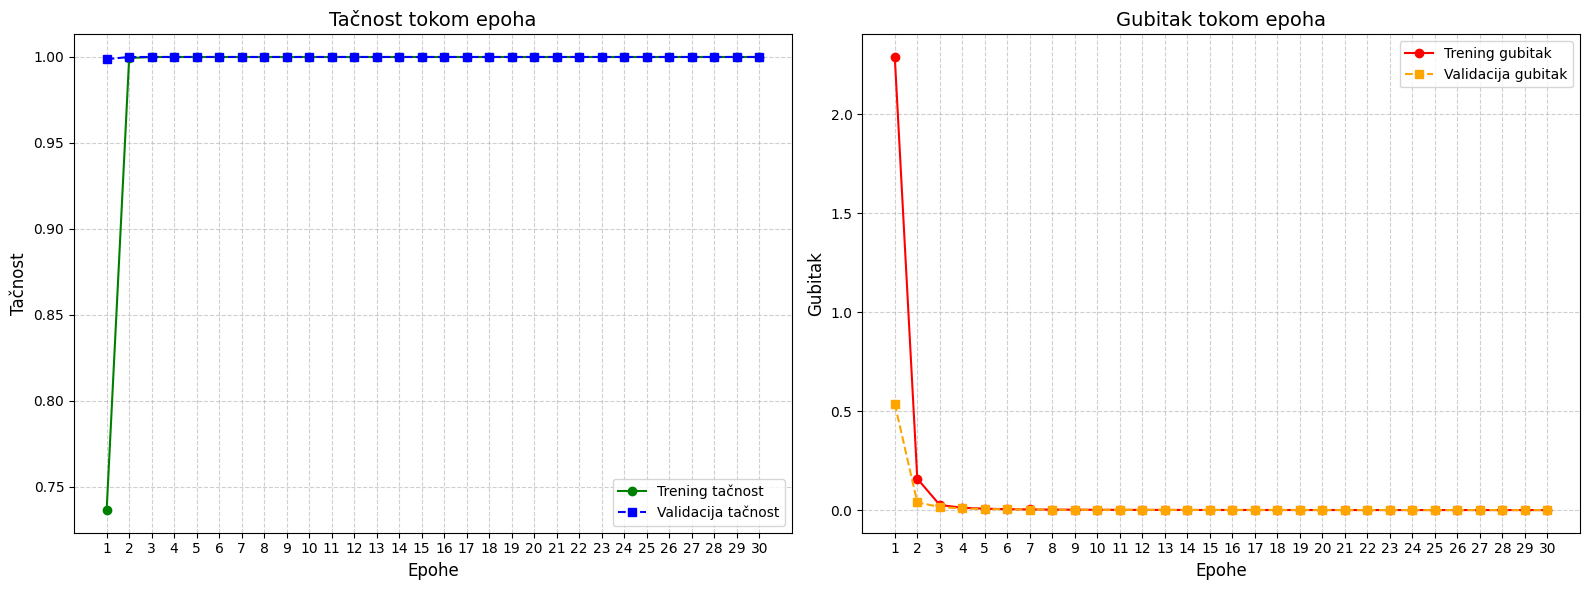

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'o-', color='green', label='Trening tačnost')
plt.plot(epochs, val_acc, 's--', color='blue', label='Validacija tačnost')
plt.title('Tačnost tokom epoha', fontsize=14)
plt.xlabel("Epohe", fontsize=12)
plt.ylabel("Tačnost", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.xticks(epochs)

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'o-', color='red', label='Trening gubitak')
plt.plot(epochs, val_loss, 's--', color='orange', label='Validacija gubitak')
plt.title('Gubitak tokom epoha', fontsize=14)
plt.xlabel("Epohe", fontsize=12)
plt.ylabel("Gubitak", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.xticks(epochs)

plt.tight_layout()
plt.show()

Zaključak:
Na osnovu prikazanih grafova, vidimo da se nakon 3-4 epohe vrijednosti tačnosti i gubitka više skoro ne mijenjaju.
To znači da se model može trenirati na manjem broju epoha bez gubitka performansi.

In [ ]:
# Treniranje modela ponovo sa samo 5 epoha
history_short = model.fit(X_train, y_train,
                          epochs=5,
                          batch_size=32,
                          validation_split=0.2)

# Prikaz nove metrike za kraći trening
acc_short = history_short.history['accuracy'][-1]
val_acc_short = history_short.history['val_accuracy'][-1]

print(f"Tačnost nakon 5 epoha - trening: {acc_short:.4f}, validacija: {val_acc_short:.4f}")

Epoch 1/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.2017e-04 - val_accuracy: 1.0000 - val_loss: 1.2524e-04
Epoch 2/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 1.1497e-04 - val_accuracy: 1.0000 - val_loss: 1.1527e-04
Epoch 3/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.0501e-04 - val_accuracy: 1.0000 - val_loss: 1.0623e-04
Epoch 4/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 9.7953e-05 - val_accuracy: 1.0000 - val_loss: 9.8205e-05
Epoch 5/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.2647e-05 - val_accuracy: 1.0000 - val_loss: 9.2077e-05
Tačnost nakon 5 epoha - trening: 1.0000, validacija: 1.0000


Na kraju radimo evaluaciju modela na test skupu podataka i ispisujemo rezultat tačnosti.

In [ ]:
results = model.evaluate(X_test, y_test)
print(f"\nTest tačnost: {results[1]*100:.2f}%")

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.9643e-05

Test tačnost: 100.00%


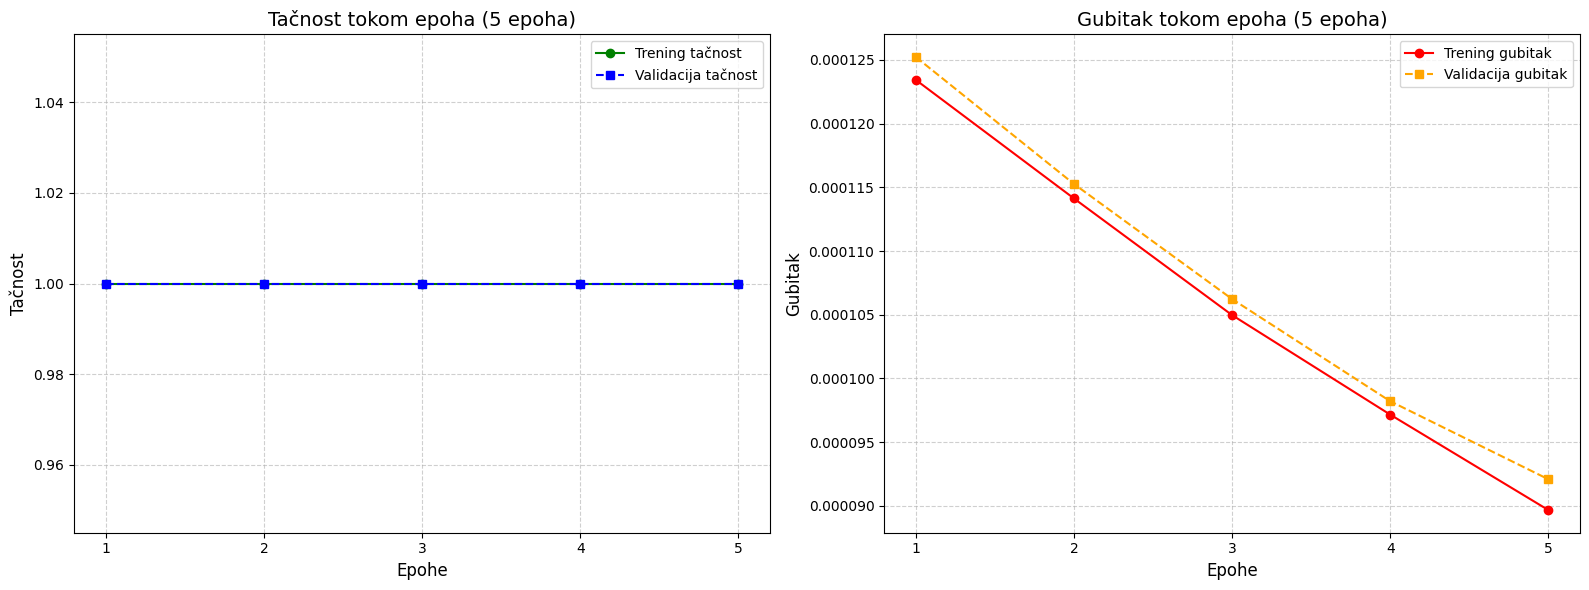

In [ ]:
import matplotlib.pyplot as plt

# Ekstrakcija metrika iz history_short objekta
acc = history_short.history['accuracy']
val_acc = history_short.history['val_accuracy']
loss = history_short.history['loss']
val_loss = history_short.history['val_loss']
epochs = range(1, len(acc) + 1)

# Crtanje grafova tačnosti i gubitka
plt.figure(figsize=(16, 6))

# Graf za tačnost
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'o-', color='green', label='Trening tačnost')
plt.plot(epochs, val_acc, 's--', color='blue', label='Validacija tačnost')
plt.title('Tačnost tokom epoha (5 epoha)', fontsize=14)
plt.xlabel("Epohe", fontsize=12)
plt.ylabel("Tačnost", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.xticks(epochs)

# Graf za gubitak
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'o-', color='red', label='Trening gubitak')
plt.plot(epochs, val_loss, 's--', color='orange', label='Validacija gubitak')
plt.title('Gubitak tokom epoha (5 epoha)', fontsize=14)
plt.xlabel("Epohe", fontsize=12)
plt.ylabel("Gubitak", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.xticks(epochs)

plt.tight_layout()
plt.show()


## Konfuzijska matrica

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


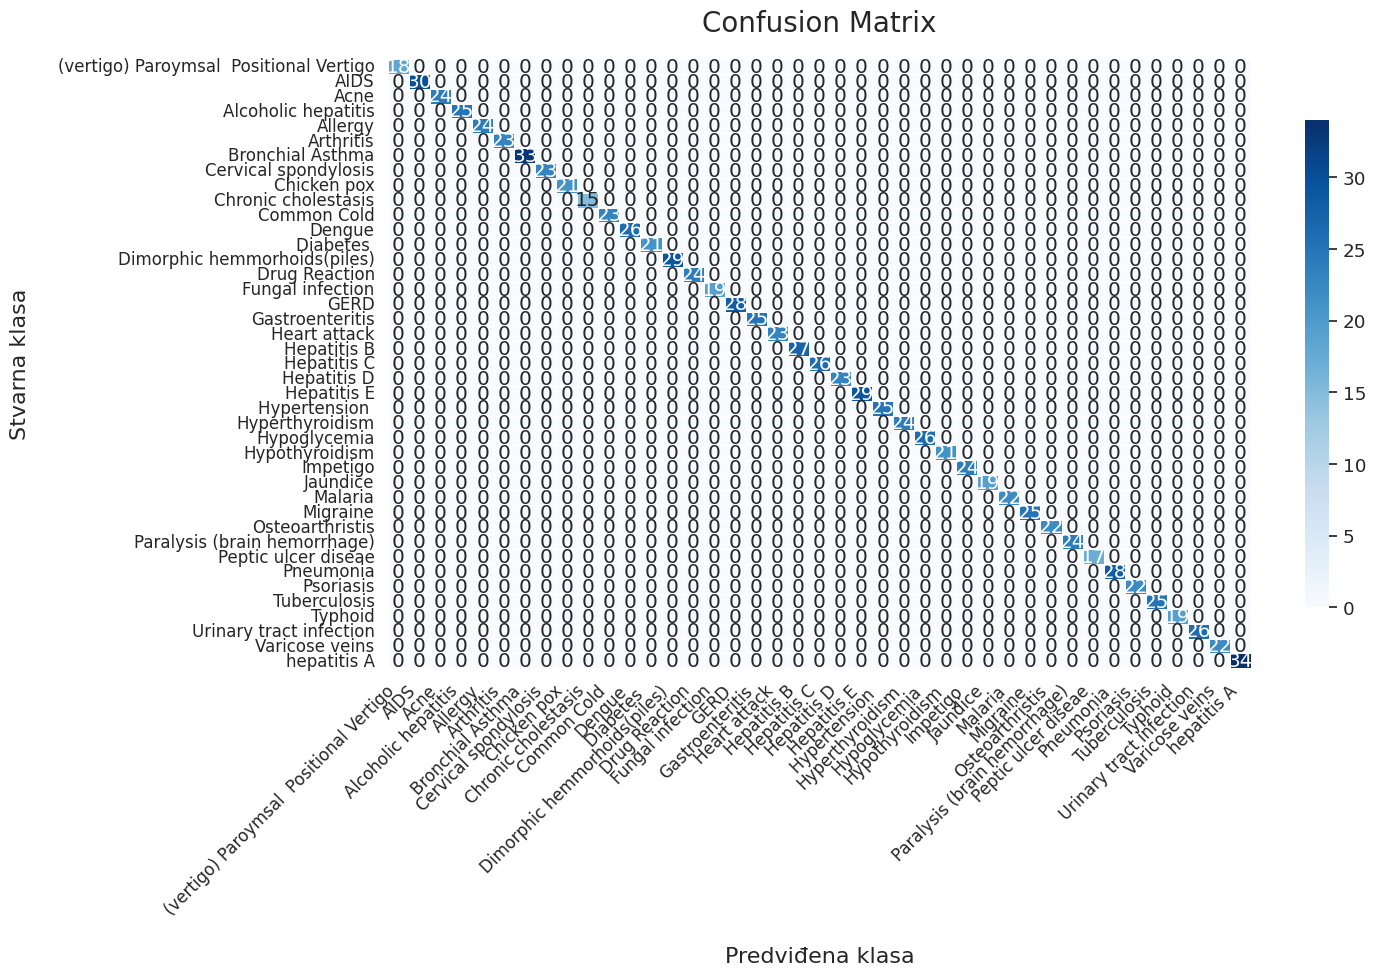

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Predikcija na test skupu
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Kreiranje confusion matrix-a
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Poboljšani prikaz
plt.figure(figsize=(15, 10))
sns.set(font_scale=1.2)  # Povećanje veličine fonta za sve oznake

# Koristimo seaborn za bolji vizualni prikaz
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_,
                linewidths=0.5,
                cbar_kws={"shrink": 0.8})

# Poboljšanje naslova i oznaka osi
plt.title('Confusion Matrix', fontsize=20, pad=20)
plt.xlabel('Predviđena klasa', fontsize=16, labelpad=20)
plt.ylabel('Stvarna klasa', fontsize=16, labelpad=20)

# Rotacija oznaka za bolju čitljivost
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

# Poboljšanje layouta
plt.tight_layout()


plt.show()

## Top 10 - cofusion matrix

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


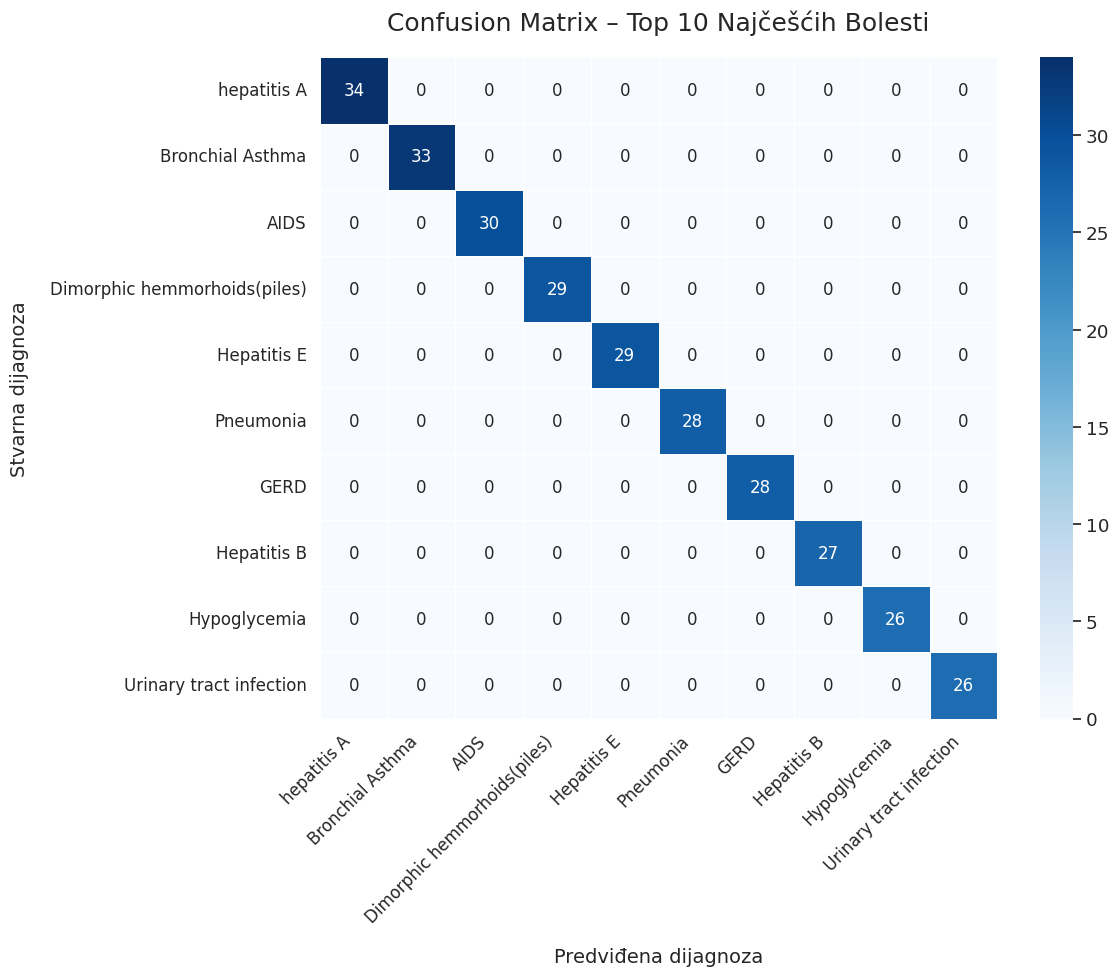

In [ ]:
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Dekodujemo y_true i y_pred u nazive bolesti
y_true_labels = le.inverse_transform(np.argmax(y_test, axis=1))
y_pred_labels = le.inverse_transform(np.argmax(model.predict(X_test), axis=1))

# Pronalazimo 10 najčešćih bolesti u test setu
counter = Counter(y_true_labels)
top10_labels = [label for label, _ in counter.most_common(10)]

# Filtriramo samo te primjere
filtered_indices = [i for i, label in enumerate(y_true_labels) if label in top10_labels]
filtered_y_true = [y_true_labels[i] for i in filtered_indices]
filtered_y_pred = [y_pred_labels[i] for i in filtered_indices]

# Kreiramo confusion matrix
filtered_cm = confusion_matrix(filtered_y_true, filtered_y_pred, labels=top10_labels)

# Izračun točnosti za top 10 bolesti
top10_accuracy = np.sum(np.diag(filtered_cm)) / np.sum(filtered_cm)

# Poboljšani prikaz
plt.figure(figsize=(12, 10))

# Koristimo seaborn za bolji i čitljiviji prikaz
ax = sns.heatmap(filtered_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=top10_labels,
                yticklabels=top10_labels,
                linewidths=0.5,
                annot_kws={"size": 12})

# Poboljšanje naslova i oznaka
plt.title("Confusion Matrix – Top 10 Najčešćih Bolesti", fontsize=18, pad=20)
plt.xlabel("Predviđena dijagnoza", fontsize=14, labelpad=15)
plt.ylabel("Stvarna dijagnoza", fontsize=14, labelpad=15)

# Rotacija i stilizacija oznaka za bolju čitljivost
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

# Poboljšanje layouta
plt.tight_layout()


plt.show()

## Ručno testiranje modela

In [ ]:
def predict_disease(input_symptoms):
    # Uklanjanje razmaka i standardizacija unosa
    input_symptoms = [s.strip().lower() for s in input_symptoms]

    # Pronađi validne simptome koji postoje u skupu podataka
    valid_symptoms = [s for s in unique_symptoms if s.lower() in input_symptoms]
    if not valid_symptoms:
        print("Nijedan validan simptom nije prepoznat.")
        return

    # Vektorizacija unosa
    input_vector = vectorize_symptoms([valid_symptoms])

    # Predikcija
    prediction = model.predict(input_vector)
    predicted_class_index = np.argmax(prediction)
    predicted_disease = le.inverse_transform([predicted_class_index])[0]

    print(f"\n Predviđena bolest: **{predicted_disease}**")

# PRIMJER UNOSA (može se modifikovati prema simptomima iz skupa)
unos_symptoma = ["vomiting", "dehydration","bellyache"]
predict_disease(unos_symptoma)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step

 Predviđena bolest: **Gastroenteritis**
